Michael Fouts  
CPE 520  
Final Project  

# Best NARX

This continues upon The [Base Case](1_Base_Case.ipynb) and attempts to optimize the NARX case for this specific data.

The changes include:
1. input and output lags
2. Activation Functions
3. Number of neurons per layer
4. Mahalanobis Distance Threshold

In [23]:
# Import Relevant Libraries

# For data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import weibull_min
from datetime import timedelta

# For Model Creation
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.save_load import save_model, load_model

# For visualization
import matplotlib.pyplot as plt

# Step 1: Data Cleaning
The first step in this project is to appropriately prepare the data.  The main goals here are to take the telemetry data, and incorporate when failures occur.

In [24]:
telemetry = pd.read_csv('data (raw)/PdM_telemetry.csv')
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
telemetry

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [25]:
failures = pd.read_csv('data (raw)/PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])
failures

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


Now that both datasets are loaded, let's combined them based on the `datetime` and `machineID` columns.  The result I'm specifically going for is an addition of a column that says if an error happened at that timestamp, what is it and if not, 0.  However, this creates an issue.  At some points, multiple errors occur, which is beyond the scope of this initial assessment.  Instead, I'm going to assume all errors are the same and simply have a 1 or 0 in the failure column where a 1 represents a failure and 0 represents normal operations.

In [26]:
data = telemetry.merge(failures, on=['datetime', 'machineID'], how='left')
data['failure'] = data['failure'].fillna(0)
data = data.drop_duplicates(subset=['datetime','machineID'])
data['failure'] = data['failure'].apply(lambda x: 1 if x != 0 else 0)
data['failure'] = data['failure'].astype(float)
data
# If you need to save data, uncomment line below
# data.to_csv('data (processed)/base_case_data.csv')

,datetime,machineID,volt,rotate,pressure,vibration,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0.0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0.0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0.0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0.0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0.0
...,...,...,...,...,...,...,...
876137,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,0.0
876138,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,0.0
876139,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,0.0
876140,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,0.0


# Step 2: Model Data Preparation

Before training the model, we must first understand how the NARX architecture works.  For this architecture in it's most simple form (which is what I'll be doing for the base case), it needs continuous data in equal time steps.  However, because we are trying to create a model where a value is accurately predicted and the appearance of failures in data would obviously be considered bad training data, we need to do identify only good operating data.  Because it needs to be continuous, we'll start by identifying the longest time intervals without failures to get the most training data.

In [27]:
# Data to identify when machine 1 had an error
errors1 = data[(data['failure']==1) & (data['machineID']==1)]

# Calculate the time difference between consecutive entries
errors1 = errors1.copy()
errors1.loc[:, 'time_diff'] = errors1['datetime'].diff()

# Select the maximum time difference (value and index)
max_time_diff = errors1['time_diff'].max()
max_time_diff_index = errors1['time_diff'].idxmax()

errors1

,datetime,machineID,volt,rotate,pressure,vibration,failure,time_diff
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,1.0,NaT
1536,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,1.0,60 days
2616,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,1.0,45 days
4056,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,1.0,60 days
5856,2015-09-02 06:00:00,1,144.094532,409.380150,106.720871,57.454990,1.0,75 days
6936,2015-10-17 06:00:00,1,178.322428,383.715256,79.704008,43.213417,1.0,45 days
8376,2015-12-16 06:00:00,1,137.701308,501.770653,108.557111,47.960218,1.0,60 days


Here, we can clearly see that the largest time difference is 75 days, so this is the time period that we'll use to train our model.  We now have to filter the dataframe to just be this data.

In [28]:
# Get the start and end dates of the time window
# The index given is the end date.  However, we need to assume some cutoff as the data will become 
# anomalous before the actual failure happens.
hours_before_issue_cutoff = 48
end_date = errors1.loc[max_time_diff_index, 'datetime'] - pd.Timedelta(hours=hours_before_issue_cutoff)

# For the start date, we need to factor in going back, as well as adding 1 since otherwise that would give
# us the index of the failure.  We assume perfect operation after the failure is noticed.
start_date = end_date - max_time_diff + pd.Timedelta(hours=hours_before_issue_cutoff + 1)

# Filter the original DataFrame for the time window
filtered_df = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
machine1_test_data = filtered_df[filtered_df['machineID']==1].reset_index(drop=True)
machine1_test_data

,datetime,machineID,volt,rotate,pressure,vibration,failure
0,2015-06-19 07:00:00,1,169.767451,484.334502,103.171170,34.327273,0.0
1,2015-06-19 08:00:00,1,195.355536,472.997054,126.038458,42.796943,0.0
2,2015-06-19 09:00:00,1,203.128060,435.684329,105.487305,34.061673,0.0
3,2015-06-19 10:00:00,1,187.740467,500.179185,116.508802,36.779509,0.0
4,2015-06-19 11:00:00,1,172.749852,453.366540,104.317749,39.187640,0.0
...,...,...,...,...,...,...,...
1747,2015-08-31 02:00:00,1,176.206170,437.599303,93.035191,42.406896,0.0
1748,2015-08-31 03:00:00,1,149.687124,440.699493,109.117967,39.673494,0.0
1749,2015-08-31 04:00:00,1,162.906842,466.047346,120.031518,39.240901,0.0
1750,2015-08-31 05:00:00,1,192.131046,397.586011,90.270395,39.807898,0.0


Now that we have the appropriate data, we have to perform some additional processing, such as normalization.

In [29]:
# Filter to only inputs and outputs
machine1_test_data = machine1_test_data[['volt','rotate','pressure','vibration']]

# Create a MinMaxScaler to get all values on scale of 0-1
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the DataFrame
machine1_test_data_normalized = pd.DataFrame(scaler.fit_transform(machine1_test_data), columns=machine1_test_data.columns)
machine1_test_data_normalized

,volt,rotate,pressure,vibration
0,0.441728,0.597701,0.428472,0.271354
1,0.708022,0.563168,0.711600,0.501429
2,0.788910,0.449517,0.457149,0.264140
3,0.628773,0.645963,0.593610,0.337968
4,0.472766,0.503376,0.442668,0.403384
...,...,...,...,...
1747,0.508736,0.455350,0.302975,0.490833
1748,0.232754,0.464793,0.502102,0.416582
1749,0.370331,0.542000,0.637226,0.404831
1750,0.674465,0.333473,0.268743,0.420233


Next, we need to split the data into train and validation.  Because this is timeseries, we can't randomly separate the observations; so, we'll split at the 90% mark for a 90/10 split.

In [30]:
# Determine the index for splitting the data into training/validation
split_index = int(len(machine1_test_data_normalized) * 0.9)  # 90/10 split

# Split the data
train_data = machine1_test_data_normalized.iloc[:split_index]
validation_data = machine1_test_data_normalized.iloc[split_index:]

# Step 3: Model Creation
Now, we can create the NARX Model using a Neural Network.  The way the library works is that it is model agnostic; so, you set up the parameters of the recurrent functionality and then simply give whatever model is applicable.  For this case, I'll be using PyTorch for an MLP architecture, modeling the architecture of the paper for the base case.

In [31]:
# Lags for inputs and recurrent output
ylag = 5
# For Inputs, lag number in list.  One list for each variable.
xlag = [[1, 2, 3, 12, 24, 36], 
        [1, 2, 3, 12, 24, 36], 
        [1, 2, 3, 12, 24, 36]]

basis_function = Polynomial(degree=1)

narx_nn = NARXNN(
    ylag=ylag,
    xlag=xlag,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=200,
    verbose=False,
    optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # for the optimizer
)

# Transform data shape for training data
x_train = train_data[['rotate','pressure','vibration']].to_numpy()
y_train = train_data['volt'].to_numpy()
y_train = np.array([y_train]).T


# Transform data shape for validation data
x_test = validation_data[['rotate','pressure','vibration']].to_numpy()
y_test = validation_data['volt'].to_numpy()
y_test = np.array([y_test]).T

# Define Neural Network (3 Layer MLP)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(23,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,1)
        )
    def forward(self, xb):
        z = self.features(xb)
        return z
    
# Assign Model
narx_nn.net = Net()
# Train NN
narx_nn.fit(X=x_train, y=y_train, 
            X_test=x_test, y_test=y_test)

# Save the model
# save_model(model=narx_nn, file_name="data (processed)/best_NARX.syspy")
# Load the model (if needed)
narx_nn = load_model(file_name="data (processed)/best_NARX_overall.syspy")

# Make predictions on test data
yhat = narx_nn.predict(X=x_test, y=y_test)

# What is the SSE?
print('Normalized MSE:', round(mean_squared_error(y_test, yhat),4))

Normalized MSE: 0.0164


# Step 4: Model Predictions
Now that the model is trained, we can perform the rest of the analysis, starting with creating a list of the model predictions for all of machine 1.  For this, we need to create a dataframe with all the predictions.  Because of the way that the transformations are created with the scaler, we'll need to convert back and forth between several formats, but the process should be overall straightforward.

In [32]:
# Get actual normalized data organized to be able to make predictions
x_all = machine1_test_data_normalized[['rotate','pressure','vibration']].to_numpy()
y_all = machine1_test_data_normalized['volt'].to_numpy()
y_all = np.array([y_all]).T

# Make predictions on all the data
y_all_hat = narx_nn.predict(X=x_all, y=y_all)

# Replace data in normalized dataframe with that which is predicted
machine1_test_data_normalized['volt'] = y_all_hat

# Un-normalize and recreate dataframe
df_recalc = pd.DataFrame(scaler.inverse_transform(machine1_test_data_normalized), columns=machine1_test_data_normalized.columns)
df_recalc

,volt,rotate,pressure,vibration
0,169.767451,484.334502,103.171170,34.327273
1,195.355539,472.997054,126.038458,42.796943
2,203.128061,435.684329,105.487305,34.061673
3,187.740469,500.179185,116.508802,36.779509
4,172.749852,453.366540,104.317749,39.187640
...,...,...,...,...
1747,183.636865,437.599303,93.035191,42.406896
1748,169.600859,440.699493,109.117967,39.673494
1749,176.781208,466.047346,120.031518,39.240901
1750,166.750171,397.586011,90.270395,39.807898


Now, let's create a plot to visualize the difference between the predictions and actual values.

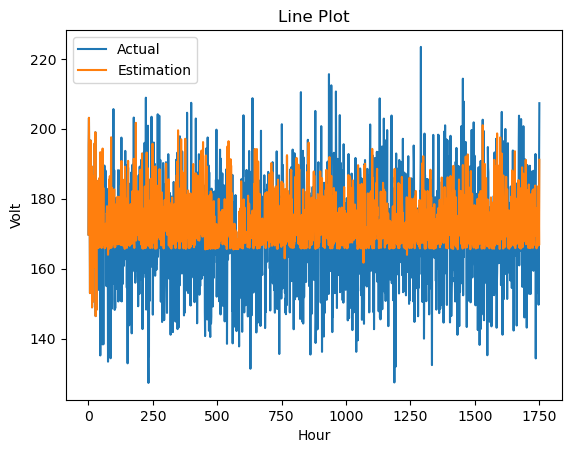

In [33]:
# Create a line plot
plt.plot(machine1_test_data.index, machine1_test_data['volt'], label='Actual')
plt.plot(df_recalc.index, df_recalc['volt'], label='Estimation')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Volt')
plt.title('Line Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()

This shows that we have significant area for improvement.  However, let's continue and complete the first analysis.

# Step 5: Mahalanobis Comparison

As mentioned in the original paper, a standard Euclidean Distance is not good enough for this comparison and instead a Mahalanobis distance will need to be used.  The advantage with the Mahalanobis distance is that we can analyze multiple variables and the variables end up getting normalized by the covariance matrix so that each is considered equally important, mathematically speaking.

In [34]:
# Create function for calculating MD
def calculateMahalanobis(y=None, data=None, cov=None): 
  
    y_mu = y - np.mean(data, axis=0) 
    if cov is None: 
        cov = np.cov(data.values.T) 
    inv_covmat = np.linalg.inv(cov) 
    left = np.dot(y_mu, inv_covmat) 
    mahal = np.dot(left, y_mu.T) 
    return np.sqrt(mahal.diagonal())

# Acutal Voltage (drop columns to keep dataframe instead of just selecting one series)
mahal = machine1_test_data.drop(columns = ['rotate','pressure','vibration'])
# Add Error Column
mahal['diff'] = machine1_test_data['volt'] - df_recalc['volt']

# numpy vector of mahal distances for each timestep
mahal_good = calculateMahalanobis(y = mahal, data = mahal)

Next, we need to take the Mahalanobis Distances and fit these to a two-parameter Wiebull Distribution.  This will give us shape and scale parameters to which we can fit to the distribution.  We can then assume that anything past a 1% chance of likelihood is considered not-normal operating conditions.  For reference, below is the two parameter Wiebull Distribution.

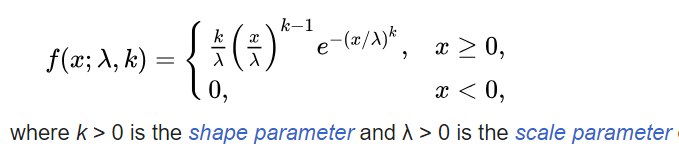

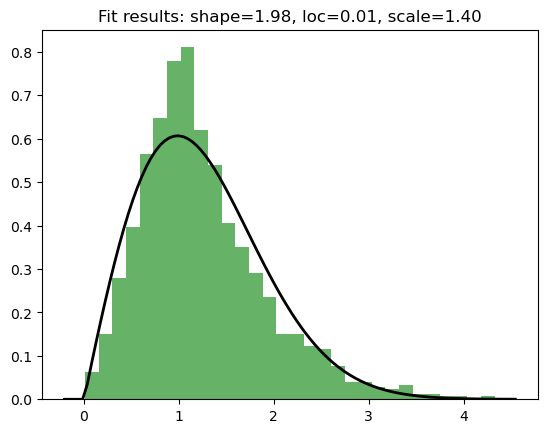

In [35]:
# Calcualte shape and scale parameters
shape, loc, scale = weibull_min.fit(mahal_good)

# Plot the data for visualization reference
# Plot the histogram of the data
plt.hist(mahal_good, bins=30, density=True, alpha=0.6, color='g')

# Plot the fitted Weibull distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = weibull_min.pdf(x, shape, loc=loc, scale=scale)
plt.plot(x, pdf, 'k', linewidth=2)

plt.title("Fit results: shape=%.2f, loc=%.2f, scale=%.2f" % (shape, loc, scale))
plt.show()

In [36]:
# Set the desired percentile (e.g., 1 percent from the top which is 99% from the CDF)
percentile = 99.5

# Calculate the value at the given percentile using the PPF
value_at_percentile = weibull_min.ppf(percentile / 100, shape, loc=loc, scale=scale)
print('99.5% Mahalanobis Distance:',round(value_at_percentile,2))

99.5% Mahalanobis Distance: 3.27


# Step 6: Evaluation Over All Data

Finally, let's graph this comparison over all data to evaluate at what points this flag would trip and where the response would be necessary.

In [37]:
# Get all data for machine 1
machine1 = data[data['machineID'] == 1][['volt','rotate', 'pressure','vibration']]
# Normalize
# scaler1 = MinMaxScaler()
machine1_normalize = pd.DataFrame(scaler.transform(machine1), columns=machine1.columns)
# Reformat inputs and outputs
x_1 = machine1_normalize[['rotate','pressure','vibration']].to_numpy()
y_1 = machine1_normalize['volt'].to_numpy()
y_1 = np.array([y_1]).T

# Create Predictions
ypredict_1 = narx_nn.predict(X=x_1, y=y_1)

# Assign Predictions to dataframe
machine1_normalize['volt'] = ypredict_1
# Un-Normalize
machine1_recalc = pd.DataFrame(scaler.inverse_transform(machine1_normalize), columns=machine1_normalize.columns)

# Calculate Mahalanobis Distance
mahal1 = machine1.drop(columns = ['rotate','pressure','vibration'])
mahal1['diff'] = machine1['volt'] - machine1_recalc['volt']

# Make sure to use training Mahalanobis data for data and covariance matrix
mahal_good = calculateMahalanobis(y = mahal1, data = mahal, cov=np.cov(mahal.values.T))

Now, let's create a plot to identify the times this threshold gets crossed and visualize it with the errors.

In [38]:
# Add mahal_good to df
graph_df = data[data['machineID'] == 1].copy()
graph_df['mahal'] = mahal_good

error_df = pd.read_csv('data (raw)/PdM_errors.csv')
error_df['datetime'] = pd.to_datetime(error_df['datetime'])
error_df = error_df[error_df['machineID'] == 1].drop_duplicates(subset=['datetime','machineID'])
error_df

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
5,2015-01-25 15:00:00,1,error4
6,2015-01-27 04:00:00,1,error1
7,2015-03-03 22:00:00,1,error2
8,2015-03-05 06:00:00,1,error1
9,2015-03-20 18:00:00,1,error1


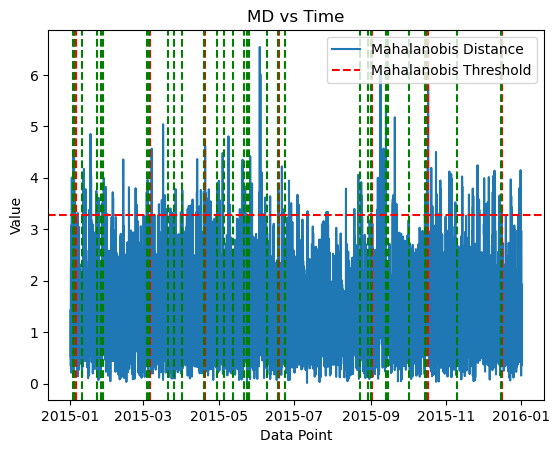

In [39]:
# Create a plot
plt.plot(graph_df['datetime'], graph_df['mahal'], label='Mahalanobis Distance')
plt.axhline(y=value_at_percentile, color='r', linestyle='--', label='Mahalanobis Threshold')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('MD vs Time')

# Add legend
plt.legend()

for value in errors1['datetime']:
    plt.axvline(x=value, color='r', linestyle='--', label='Failure')

for value in error_df['datetime']:
    plt.axvline(x=value, color='g', linestyle='--', label='Errors')

# Show the plot
plt.show()

In [40]:
final_df = data[data['machineID'] == 1].copy()
final_df['mahal'] = mahal_good
# final_df['datetime'] = machine1['datetime']
final_df = final_df[['datetime','mahal']]
final_df = final_df[final_df['mahal'] >= value_at_percentile]

# Comparison
final_df['within_time'] = 0
time_threshold = 48 # hours

# For correct/incorrect predictions
# Errors
for index, row in final_df.iterrows():
    within_time = any(
        ((row['datetime'] - error_df['datetime']).abs() <= timedelta(hours=time_threshold)) &
        ((row['datetime'] - error_df['datetime']) < timedelta(hours=0))
    )
    final_df.at[index, 'within_time'] = 1 if within_time else final_df.at[index, 'within_time']
# Failures
for index, row in final_df.iterrows():
    within_time = any(
        ((row['datetime'] - errors1['datetime']).abs() <= timedelta(hours=time_threshold)) &
        ((row['datetime'] - errors1['datetime']) < timedelta(hours=0))
    )
    final_df.at[index, 'within_time'] = 1 if within_time else final_df.at[index, 'within_time']

# For missed Errors and Failures
error_failure = pd.DataFrame(pd.concat([error_df['datetime'],errors1['datetime']])).reset_index(drop = True)
# Comparison
error_failure['within_time'] = 0

# For correct/incorrect predictions
# Errors
for index, row in error_failure.iterrows():
    within_time = any(
        ((row['datetime'] - final_df['datetime']).abs() <= timedelta(hours=time_threshold)) &
        ((row['datetime'] - final_df['datetime']) > timedelta(hours=0))
    )
    error_failure.at[index, 'within_time'] = 1 if within_time else error_failure.at[index, 'within_time']

error_failure

,datetime,within_time
0,2015-01-03 07:00:00,1
1,2015-01-03 20:00:00,1
2,2015-01-04 06:00:00,1
3,2015-01-10 15:00:00,0
4,2015-01-22 10:00:00,1
5,2015-01-25 15:00:00,1
6,2015-01-27 04:00:00,1
7,2015-03-03 22:00:00,1
8,2015-03-05 06:00:00,1
9,2015-03-20 18:00:00,1


In [41]:
correct = final_df['within_time'].sum()
print('True Positives:', correct)
print('False Positives:', len(final_df) - correct)

events_correctly_handled = error_failure['within_time'].sum()
events_missed = len(error_failure) - events_correctly_handled
print('Events Predicted:', events_correctly_handled)
print('Events Missed:', events_missed)

True Positives: 55
False Positives: 151
Events Predicted: 35
Events Missed: 5


# Step 7: Economic Analysis

While the previous printed results do tell about performance, it is difficult to compare the performance between different models.  For this reason, it was decided to do a simple economic analysis to give a financial cost that can be more directly compared between models.  For this analysis, 6 possibilities were categorized and given costs.  Because of the synthetic nature of the data, a use case was assumed of servers in a data farm; however, it is important to note that these economics will greatly change the results of the analysis depending on the use case.  Below is a table showing what the possibilities are for this case.

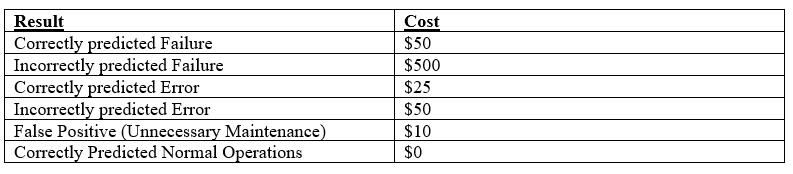

Due to complications with consecutive records, two back to back flags are considered as only one flag and the total number of records is then decreased by 1.  This is to reflect the fact that a person would only perform maintenance check for two consecutive flags.  This number then gets subtracted from the False Positives above.

In [42]:
test = data[data['machineID']==1]

# Comparison
test['within_time'] = 1
time_threshold = 48 # hours

# For correct/incorrect predictions
# Errors
for index, row in test.iterrows():
    within_time = any(
        ((row['datetime'] - error_df['datetime']).abs() <= timedelta(hours=time_threshold)) &
        ((row['datetime'] - error_df['datetime']) < timedelta(hours=0))
    )
    test.at[index, 'within_time'] = 0 if within_time else test.at[index, 'within_time']
# Failures
for index, row in test.iterrows():
    within_time = any(
        ((row['datetime'] - errors1['datetime']).abs() <= timedelta(hours=time_threshold)) &
        ((row['datetime'] - errors1['datetime']) < timedelta(hours=0))
    )
    test.at[index, 'within_time'] = 0 if within_time else test.at[index, 'within_time']

C:\Users\Michael\AppData\Local\Temp\ipykernel_4572\2818222629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['within_time'] = 1


In [43]:
test_df = final_df[final_df['within_time']==0].reset_index(drop=True)

# Calculate the time difference between consecutive timestamps
test_df['time_diff'] = test_df['datetime'].diff()

# Check if the time difference is exactly one hour (1 hour = 3600 seconds)
test_df['consecutive'] = test_df['time_diff'] == pd.Timedelta(hours=1)

test_df['consecutive'].sum()
# test_df

9

In [44]:
# Final Cost
0*500 + 7*50 + 5*50 + 28*25 + (151-9)*10

2720